In [6]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import time
from itertools import product
import os
import random
import re
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
from scipy.signal import savgol_filter
import matplotlib.pyplot as plot
import copy
from sklearn.metrics import mean_squared_error as mse

In [7]:
#random seed 
def init_random_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.enabled = False       
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

init_random_seed(0)

In [8]:
# read data
# delete some columns and rows
data = pd.read_csv('all_data_new.csv')
data = data.iloc[1:-3, 1:]
data.shape


(366, 62)

In [9]:
# count missing value
print(data.isnull().sum(axis=0)[:50])
print(data.isnull().sum(axis=0)[50:])



date                              0
twitter_positive                  6
twitter_neutral                   6
twitter_negative                  6
twitter_price                     0
coin_price_bitcoin                0
coin_price_ethereum               0
coin_price_dogecoin               0
gold_price                      106
bitcoin_trend                    51
itb_btc_count                     0
itb_btc_prince                    0
all_time_highers                  0
all_time_lowers                   0
average_balance                   0
seconds                           0
average_transaction_size          0
new_addresses                     0
active_addresses                  0
zero_balance_addresses            0
daily_active_address_price        0
hash_rate                         0
average_size_in_bytes             0
volume_share_antpool              0
volume_share_btccom               0
volume_share_binance              0
volume_share_huobi_pool           0
inflows_antpool             

In [10]:
# convert gold price from string number to float 
def str2num(gold_str):
    gold_price = float(gold_str.replace(',', ''))
    return gold_price
data['gold_price'] = data['gold_price'].fillna(method='pad')
data['gold_price'] = data['gold_price'].apply(str2num)


In [11]:
# delete features with too many mising value

drop_columns_1 = [i for i in ['twitter_positive', 'twitter_neutral', 'twitter_negative', 'twitter_price', 'bitcoin_trend'] if i in data.columns]
data = data.drop(columns=drop_columns_1)

# delete repetitive features
drop_columns_2 = [i for i in ['twitter_price', 'itb_btc_prince'] if i in data.columns]
data = data.drop(columns=drop_columns_2)

# padding missing value
data = data.fillna(method='pad')

bitcoin_price = data['coin_price_bitcoin']

##
data_extend = copy.copy(data)

In [12]:
#  convert features to 0-1 scale
scaler = MinMaxScaler(feature_range=(0, 1))
scaler_price = MinMaxScaler(feature_range=(0, 1))
scaler_price.fit_transform(np.array(data.iloc[:,1]).reshape(-1, 1))
data.iloc[:,1:] = scaler.fit_transform(data.iloc[:,1:])
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 1 to 366
Data columns (total 56 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   date                              366 non-null    object 
 1   coin_price_bitcoin                366 non-null    float64
 2   coin_price_ethereum               366 non-null    float64
 3   coin_price_dogecoin               366 non-null    float64
 4   gold_price                        366 non-null    float64
 5   itb_btc_count                     366 non-null    float64
 6   all_time_highers                  366 non-null    float64
 7   all_time_lowers                   366 non-null    float64
 8   average_balance                   366 non-null    float64
 9   seconds                           366 non-null    float64
 10  average_transaction_size          366 non-null    float64
 11  new_addresses                     366 non-null    float64
 12  active_a

In [13]:
data[:10]

,date,coin_price_bitcoin,coin_price_ethereum,coin_price_dogecoin,gold_price,itb_btc_count,all_time_highers,all_time_lowers,average_balance,seconds,...,上证指数_close,美元指数期货_close,WTI原油期货_close,Count,黄金期货_close,XLK_close,Dow_Jones_Commodity_close,cci_close,美国标准普尔500指数_close,Dow_Jones_Commodity_Energy_close
1,2020/9/14,0.001356,0.009181,0.000392,0.988841,0.710623,0.000547,1.000000,0.005600,0.061118,...,0.123092,0.664328,0.036332,0.710623,0.977908,0.095228,0.038699,0.019382,0.112782,0.025605
2,2020/9/15,0.006322,0.009409,0.000450,0.955364,0.670118,0.000542,0.991071,0.011379,0.120176,...,0.156978,0.697136,0.061542,0.670118,0.986030,0.118475,0.045894,0.015832,0.126366,0.045931
3,2020/9/16,0.008669,0.007594,0.000450,1.000000,0.711456,0.000536,0.982143,0.013402,0.133448,...,0.133356,0.724825,0.108008,0.711456,1.000000,0.081770,0.073686,0.016353,0.114282,0.082662
4,2020/9/17,0.008614,0.012067,0.000421,0.908207,0.720404,0.000528,0.973214,0.014260,0.052260,...,0.106279,0.675137,0.128028,0.720404,0.930474,0.062398,0.088371,0.019204,0.092375,0.105309
5,2020/9/18,0.009204,0.012717,0.000406,0.960763,0.637174,0.000522,0.973214,0.014620,0.089609,...,0.242166,0.671914,0.131488,0.637174,0.971410,0.022431,0.102628,0.018283,0.063499,0.107553
6,2020/9/19,0.010855,0.012416,0.000406,0.960763,0.511119,0.000517,0.964286,0.016945,0.156823,...,0.242166,0.671914,0.131488,0.511119,0.971410,0.022431,0.102628,0.019190,0.063499,0.107553
7,2020/9/20,0.009163,0.010657,0.000392,0.960763,0.379195,0.000513,0.964286,0.014599,0.173299,...,0.242166,0.671914,0.131488,0.379195,0.971410,0.022431,0.102628,0.014709,0.063499,0.107553
8,2020/9/21,0.004658,0.005598,0.000290,0.811375,0.540552,0.000509,0.964286,0.007973,0.170616,...,0.199683,0.810734,0.087000,0.540552,0.802794,0.036297,0.047733,0.004281,0.033953,0.065052
9,2020/9/22,0.000655,0.001963,0.000174,0.799136,0.579298,0.000504,0.964286,0.003234,0.250938,...,0.114033,0.874075,0.094167,0.579298,0.794672,0.072594,0.047175,0.006629,0.060499,0.064337
10,2020/9/23,0.000000,0.000430,0.000160,0.681785,0.697201,0.000500,0.955357,0.000000,0.179636,...,0.124900,0.954675,0.102323,0.697201,0.663093,0.000000,0.040802,0.000000,0.000000,0.075660


In [14]:
# concat data within a time window
# split training and testing set

def split_data(data, price, window, split_ratio):
    price = price.to_numpy()
    data = data.iloc[:, 1:]
    X, y = [], []

    # create all possible sequences of length seq_len
    for index in range(len(data) - window):   
        X.append(data[index: index + window]) 
        y.append(price[index + window]) 
    
    X, y = np.array(X), np.array(y).reshape(-1,1)
        
    test_set_size = int(np.round(split_ratio*data.shape[0]));
    train_set_size = data.shape[0] - (test_set_size);
    
    x_train = X[:train_set_size]
    y_train = y[:train_set_size]
    
    x_test = X[train_set_size:]
    y_test = y[train_set_size:]
    
    x_train = torch.from_numpy(x_train).type(torch.Tensor)
    x_test = torch.from_numpy(x_test).type(torch.Tensor)
    y_train = torch.from_numpy(y_train).type(torch.Tensor)
    y_test = torch.from_numpy(y_test).type(torch.Tensor)
    
    return [x_train, y_train, x_test, y_test]

all_data = split_data(data, bitcoin_price, 10, 0.2)

In [15]:
## LSTM model
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        out, (hn, cn) = self.lstm(x)
        out = self.fc(out[:, -1, :]) 
        return out

Training epoch  0 MSE:  0.3618645668029785
Training epoch  20 MSE:  0.018359770998358727
Training epoch  40 MSE:  0.0027389577589929104
Training epoch  60 MSE:  0.003316698130220175
Training epoch  80 MSE:  0.0028881970793008804
train 5 rounds in total, this is the 0 th round, RMSE is0.043214183300733566 

Training epoch  0 MSE:  0.34949031472206116
Training epoch  20 MSE:  0.009240277111530304
Training epoch  40 MSE:  0.0054707834497094154
Training epoch  60 MSE:  0.0029721681494265795
Training epoch  80 MSE:  0.002721790922805667
train 5 rounds in total, this is the 1 th round, RMSE is0.04568817466497421 

Training epoch  0 MSE:  0.33345314860343933
Training epoch  20 MSE:  0.015268449671566486
Training epoch  40 MSE:  0.004078330937772989
Training epoch  60 MSE:  0.0033113863319158554
Training epoch  80 MSE:  0.0027421447448432446
train 5 rounds in total, this is the 2 th round, RMSE is0.047878626734018326 

Training epoch  0 MSE:  0.2620851397514343
Training epoch  20 MSE:  0.01412

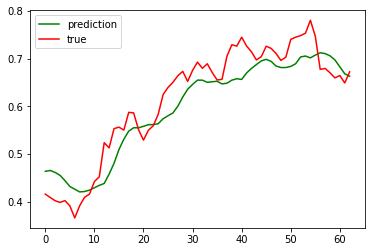

In [16]:
# train
def train(all_data, hidden_size, num_epochs, lr, reg, seed=None, plot=True):
    if seed:
        init_random_seed(seed)
    x_train, y_train, x_test, y_test = all_data[0], all_data[1], all_data[2], all_data[3]
    input_dim  = x_train.shape[-1]
    model = LSTM(input_dim=input_dim, hidden_dim=hidden_size, output_dim=1, num_layers=2)
    criterion = torch.nn.MSELoss(reduction='mean')
    optimiser = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=reg)

    hist = np.zeros(num_epochs)
    lstm = []
    for t in range(num_epochs):
        y_train_pred = model(x_train)
        loss = criterion(y_train_pred, y_train)
        hist[t] = loss.item()
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()
        if t % 20 == 0:
            print("Training epoch ", t, "MSE: ", loss.item())



    y_test_pred = model(x_test)
    loss = criterion(y_test_pred, y_test).item()

    test_set_size = int(np.round(0.2*data.shape[0]))
    train_set_size = data.shape[0] - (test_set_size)

    y_test_pred = y_test_pred.detach().numpy()
    y_test_true = y_test.detach().numpy()


    RMSE = mse(y_test_true, y_test_pred, squared=False)
    
    if plot:
        axis = list(range(len(y_test_pred)))
        plt.plot(axis, y_test_pred, c='g', label='prediction')
        plt.plot(axis, y_test_true, c='r', label='true')
        plt.legend()

    return RMSE, model

# train n times and get the average RMSE
def get_avg_se(run_times, all_data, hidden_size, num_epochs, lr, reg):
    RMSE_sum = 0
    for i in range(run_times):
        if i == 0:
            RMSE, model = train(all_data, hidden_size, num_epochs, lr, reg, i)
        else:
            RMSE, model = train(all_data, hidden_size, num_epochs, lr, reg, i, False)
        RMSE_sum += RMSE
        print(f'train {run_times} rounds in total, this is the {i} th round, RMSE is{RMSE}', '\n')
    RMSE_avg = RMSE_sum / run_times
    print(f'average RMSE is {RMSE_avg}')
    return RMSE_avg, model


# train with original features
RMSE, _ = get_avg_se(5, all_data, 64, 100, 0.01, 0.01)


In [17]:
# add change rate features
data_extend['btc_lag_1'] = data_extend['coin_price_bitcoin'].shift(1)
data_extend['btc_lag_3'] = data_extend['coin_price_bitcoin'].shift(3)
data_extend['btc_lag_5'] = data_extend['coin_price_bitcoin'].shift(5)

data_extend['cci_lag_1'] = data_extend['cci_close'].shift(1)
data_extend['cci_lag_3'] = data_extend['cci_close'].shift(3)
data_extend['cci_lag_5'] = data_extend['cci_close'].shift(5)

data_extend= data_extend[5:]

data_extend['btc_price_diff_1'] = (data_extend['coin_price_bitcoin']-data_extend['btc_lag_1'])/data_extend['btc_lag_1']
data_extend['btc_price_diff_3'] = (data_extend['coin_price_bitcoin']-data_extend['btc_lag_3'])/data_extend['btc_lag_3']
data_extend['brc_price_diff_5'] = (data_extend['coin_price_bitcoin']-data_extend['btc_lag_5'])/data_extend['btc_lag_5']
data_extend['cci_diff_1'] = (data_extend['cci_close']-data_extend['cci_lag_1'])/data_extend['cci_lag_1']
data_extend['cci_diff_3'] = (data_extend['cci_close']-data_extend['cci_lag_3'])/data_extend['cci_lag_3']
data_extend['cci_diff_5'] = (data_extend['cci_close']-data_extend['cci_lag_5'])/data_extend['cci_lag_5']


data_extend = data_extend.drop(columns=['btc_lag_1', 'btc_lag_3', 'btc_lag_5', 'cci_lag_1', 'cci_lag_3', 'cci_lag_5'])
data_extend.iloc[:,1:] = scaler.fit_transform(data_extend.iloc[:,1:]);


Training epoch  0 MSE:  0.1896088868379593
Training epoch  20 MSE:  0.00440253084525466
Training epoch  40 MSE:  0.0016130267176777124
Training epoch  60 MSE:  0.0015411463100463152
Training epoch  80 MSE:  0.001394843915477395
train 5 rounds in total, this is the 0 th round, RMSE is0.038876064121723175 

Training epoch  0 MSE:  0.20832405984401703
Training epoch  20 MSE:  0.002689860761165619
Training epoch  40 MSE:  0.002453911118209362
Training epoch  60 MSE:  0.0018086412455886602
Training epoch  80 MSE:  0.0013485443778336048
train 5 rounds in total, this is the 1 th round, RMSE is0.026429323479533195 

Training epoch  0 MSE:  0.4614527225494385
Training epoch  20 MSE:  0.013291124254465103
Training epoch  40 MSE:  0.002345921006053686
Training epoch  60 MSE:  0.001607787562534213
Training epoch  80 MSE:  0.0014432393945753574
train 5 rounds in total, this is the 2 th round, RMSE is0.037380967289209366 

Training epoch  0 MSE:  0.3676340579986572
Training epoch  20 MSE:  0.0117532

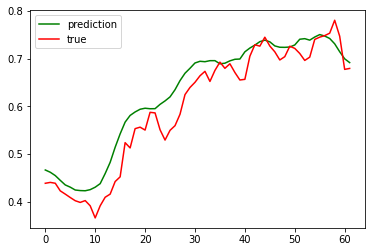

In [18]:
# train new dataset
all_data_extend = split_data(data_extend, bitcoin_price, 10, 0.2)
RMSE, _ = get_avg_se(5, all_data_extend, 64, 100, 0.01, 0.01)

In [19]:
# selecting feature with three algorithms

def feature_select(data):
    
    X = data.iloc[:, 2:]
    Y = data.iloc[:, 1]
    names = data.columns[2:]
    
    def ridge():
        ridge = Ridge(alpha=5)
        ridge.fit(X, Y)
        scores = [i[0] for i in scaler.fit_transform([[np.abs(i)] for i in ridge.coef_])]
        return scores
    
    def randomForest():
        rf = RandomForestRegressor()
        rf.fit(X, Y)
        scores = scaler.fit_transform(list(map(lambda x: [round(x, 4)], rf.feature_importances_)))
        scores = [i[0] for i in scores]
        return scores
    
    def cov():
        scores = [np.abs(i) for i in data.corr()['coin_price_bitcoin'][1:]]
        return scores 
    
    crit1, crit2, crit3 = ridge(), randomForest(), cov()
    all_crit = list(zip(names, [(i[0]+i[1]+i[2])/3 for i in list(zip(crit1, crit2, crit3))]))
    return all_crit


all_crit_new = feature_select(data_extend)

for i in sorted(all_crit_new, key= lambda x:x[1]):
    print(i)

('btc_price_diff_1', 0.01603633558402825)
('rewards_transaction_fees', 0.02315600265708605)
('new_addresses', 0.02665633253159337)
('cci_diff_1', 0.026996112970005887)
('btc_price_diff_3', 0.027731385888403532)
('seconds', 0.03255203800950302)
('average_size_in_bytes', 0.036797167029803145)
('zero_balance_addresses', 0.03978493567444246)
('cci_diff_3', 0.042266742341446194)
('rewards_rewards', 0.04833540299224854)
('volume_share_btccom', 0.05361365818616728)
('brc_price_diff_5', 0.05366713897815898)
('itb_btc_count', 0.07258659305800882)
('Count', 0.07258659305800894)
('cci_diff_5', 0.07898659774269036)
('volume_share_huobi_pool', 0.08273764986961683)
('outflows_binance', 0.08668249495841977)
('number_of_transactions', 0.0884087970115806)
('volume_share_binance', 0.08850002226837962)
('reverses_huobi_pool', 0.09083865076666059)
('美元指数期货_close', 0.0999445735992226)
('active_addresses', 0.10344468610126778)
('total_flows_binance', 0.11000764759219123)
('volume_share_antpool', 0.115051857

Training epoch  0 MSE:  0.20687389373779297
Training epoch  20 MSE:  0.007611468434333801
Training epoch  40 MSE:  0.002353695221245289
Training epoch  60 MSE:  0.0015514077385887504
Training epoch  80 MSE:  0.0015285812551155686
train 5 rounds in total, this is the 0 th round, RMSE is0.023961273953318596 

Training epoch  0 MSE:  0.3466865122318268
Training epoch  20 MSE:  0.008967005647718906
Training epoch  40 MSE:  0.0045844148844480515
Training epoch  60 MSE:  0.001987028867006302
Training epoch  80 MSE:  0.0015413913642987609
train 5 rounds in total, this is the 1 th round, RMSE is0.026816388592123985 

Training epoch  0 MSE:  0.32830914855003357
Training epoch  20 MSE:  0.014177188277244568
Training epoch  40 MSE:  0.002507468219846487
Training epoch  60 MSE:  0.0015332360053434968
Training epoch  80 MSE:  0.0015487202908843756
train 5 rounds in total, this is the 2 th round, RMSE is0.026408912613987923 

Training epoch  0 MSE:  0.2700241506099701
Training epoch  20 MSE:  0.0127

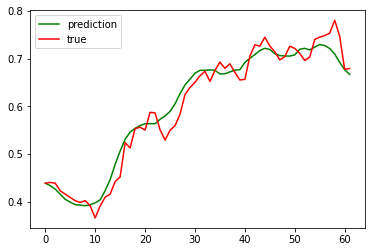

In [20]:
# delete features with low score
features_new = [i[0] for i in all_crit_new if i[0] not in ['rewards_transaction_fees', 'new_addresses','seconds','average_size_in_bytes']]
data_extend_reduced = data_extend.loc[:, features_new]
all_data_extend_reduced = split_data(data_extend_reduced, bitcoin_price, 10, 0.2)
RMSE, _ = get_avg_se(5, all_data_extend_reduced, 64, 100, 0.01, 0.01)


In [21]:
# find features with high volatility 

def avg_diff(feature):
    mov_avg = savgol_filter(feature, 13, 5, mode= 'nearest')
    SE = np.sum((feature - mov_avg)**2)
    return SE
diff = []
for f in data_extend_reduced.columns[1:]:
    diff.append([f, avg_diff(data_extend_reduced[f])])
diff = sorted(diff, key = lambda x:x[1])
diff

[['all_time_lowers', 0.00598936894843655],
 ['reverses_binance', 0.02761406408236489],
 ['Dow_Jones_Commodity_close', 0.04422097854156232],
 ['美国标准普尔500指数_close', 0.04832624270611778],
 ['道琼斯工业平均指数_close', 0.0607759237522826],
 ['Dow_Jones_Commodity_Energy_close', 0.06623138592541863],
 ['daily_active_address_price', 0.07196825785976199],
 ['WTI原油期货_close', 0.07772213764737124],
 ['coin_price_dogecoin', 0.07963381695269467],
 ['average_balance', 0.08282451822867654],
 ['XLK_close', 0.0858649411458654],
 ['cci_close', 0.11524769110298201],
 ['EEM_close', 0.12510881621528425],
 ['all_time_highers', 0.1573545461804305],
 ['reverses_btccom', 0.18077522932504358],
 ['reverses_huobi_pool', 0.2227997285528378],
 ['美元指数期货_close', 0.23017242527516674],
 ['黄金期货_close', 0.29090848211513826],
 ['上证指数_close', 0.3154983934793706],
 ['gold_price', 0.3348671599530257],
 ['btc_total_fees', 0.3557472150049243],
 ['VIX恐慌指数_close', 0.44773832079687037],
 ['average_transaction_size', 0.6426501724044343],
 

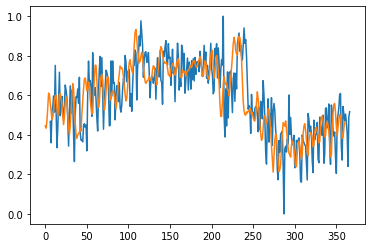

In [22]:
# smoothing
plt.plot(data_extend_reduced['active_addresses'])
plt.plot(savgol_filter(data_extend_reduced['active_addresses'], 17, 7, mode= 'nearest'))

In [23]:
# smooth features with high volatility 
data_smooth = copy.copy(data_extend_reduced)
for i in diff:
    if i[1] >= 3.5:
        data_smooth[i[0]] = savgol_filter(data_smooth[i[0]], 17, 7, mode= 'nearest')


Training epoch  0 MSE:  0.4029618501663208
Training epoch  20 MSE:  0.014819237403571606
Training epoch  40 MSE:  0.0029248083010315895
Training epoch  60 MSE:  0.0021589091047644615
Training epoch  80 MSE:  0.001491654315032065
train 5 rounds in total, this is the 0 th round, RMSE is0.027757761999964714 

Training epoch  0 MSE:  0.34668809175491333
Training epoch  20 MSE:  0.008957067504525185
Training epoch  40 MSE:  0.004576211795210838
Training epoch  60 MSE:  0.001991165801882744
Training epoch  80 MSE:  0.0015441213035956025
train 5 rounds in total, this is the 1 th round, RMSE is0.02677411213517189 

Training epoch  0 MSE:  0.32832396030426025
Training epoch  20 MSE:  0.014198679476976395
Training epoch  40 MSE:  0.0025145038962364197
Training epoch  60 MSE:  0.0015366027364507318
Training epoch  80 MSE:  0.0015522363828495145
train 5 rounds in total, this is the 2 th round, RMSE is0.026401696726679802 

Training epoch  0 MSE:  0.2700165808200836
Training epoch  20 MSE:  0.01272

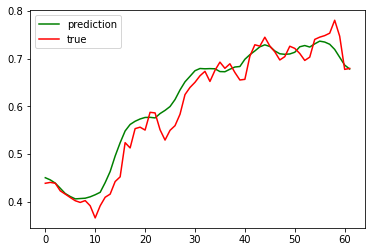

In [24]:
# train one more time
all_data_smooth = split_data(data_smooth, bitcoin_price, 10, 0.2)
RMSE, _ = get_avg_se(5, all_data_smooth, 64, 100, 0.01, 0.01)

Training epoch  0 MSE:  0.4029618501663208
Training epoch  20 MSE:  0.014819237403571606
Training epoch  40 MSE:  0.0029248083010315895
Training epoch  60 MSE:  0.0021589091047644615
Training epoch  80 MSE:  0.001491654315032065
train 5 rounds in total, this is the 0 th round, RMSE is0.027757761999964714 

Training epoch  0 MSE:  0.34668809175491333
Training epoch  20 MSE:  0.008957067504525185
Training epoch  40 MSE:  0.004576211795210838
Training epoch  60 MSE:  0.001991165801882744
Training epoch  80 MSE:  0.0015441213035956025
train 5 rounds in total, this is the 1 th round, RMSE is0.02677411213517189 

Training epoch  0 MSE:  0.32832396030426025
Training epoch  20 MSE:  0.014198679476976395
Training epoch  40 MSE:  0.0025145038962364197
Training epoch  60 MSE:  0.0015366027364507318
Training epoch  80 MSE:  0.0015522363828495145
train 5 rounds in total, this is the 2 th round, RMSE is0.026401696726679802 

Training epoch  0 MSE:  0.2700165808200836
Training epoch  20 MSE:  0.01272

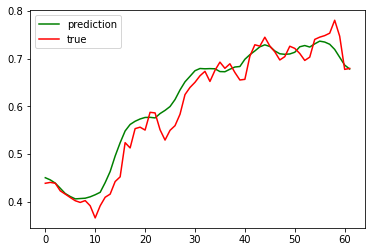

In [25]:
# get the best model so far
_, best_model = get_avg_se(5, all_data_smooth, 64, 100, 0.01, 0.01)

In [26]:
# get the data of last 10 days to predict the next day
print(data.iloc[-1, 0])
latest_x = np.array(data_smooth.iloc[351:, 1:])
latest_x = torch.Tensor(latest_x)
latest_x = latest_x.unsqueeze(0)
latest_x.shape

2021/9/14


torch.Size([1, 10, 55])

In [27]:
# prediction result
latest_y = best_model(latest_x).detach().numpy()
latest_y = scaler_price.inverse_transform(latest_y)
print(f'we predict next day (2021/9/15) bitcoin price will be {latest_y}')


we predict next day (2021/9/15) bitcoin price will be [[45858.684]]
